# Introduction

This notebook documents initial attempts to create a machine learning model to predict energy consumption from weather data. 

# Approach

Based on initial explorations of the data, there is considerable variance between buildings and in different seasons. Therefore, my approach will be to develop four models for each building, one for each season. If even more accurate results are desired, it would be possible to develop one model for each month. Even with four models for each building, I can run a building through the models in a matter of seconds on my personal machine. Run time should not be an issue with these models. 

This notebook will explore a linear model and a Random Forest. When starting a machine learning project, these are my two "go-to" models to try first. The linear model is extremely simple but can demonstrate impressive results if the underlying data
is indeed linear. The Random Forest model is an ensemble model that can capture complex relationships within a dataset. There are numerous benefits to a Random Forest including that it performs feature selection for you (no need to remove highly correlated variables) and it can return feature importances. The Random Forest model therefore has some amount of interpretability and the trees themselves can be displayed. Further work should explore the use of deep neural networks as these are able to capture extremely complex relationships. 

In [1]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from dateutil import parser
from tpot import TPOTRegressor
import tensorflow as tf
import feather
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
df = pd.read_csv('python_data/f-APS_weather.csv')
type(df['timestamp'])
float(df.ix[1, 'timestamp'])

ValueError: could not convert string to float: '2013-10-16 00:15:00'

In [24]:
import datetime, time
dt = [datetime.datetime.strptime(df.ix[index, 'timestamp'], "%Y-%m-%d %H:%M:%S") for index, _ in enumerate(df['timestamp'])]

In [32]:
min_time = min(dt)

In [33]:
seconds = [(time.mktime(date.timetuple()) - time.mktime(min_time.timetuple())) for date in dt]

In [34]:
seconds[1:10]

[900.0, 1800.0, 2700.0, 3600.0, 4500.0, 5400.0, 6300.0, 7200.0, 8100.0]

In [38]:
from model_utilities import get_features_labels
import autoreload

%load_ext autoreload

In [44]:
list(df[4:5].index)

[4]

In [46]:
%autoreload

features, labels = get_features_labels(df)

In [49]:
features.shape

(26496, 26)

In [52]:
%autoreload

raw_df = get_features_labels(df, raw_df = True)

In [65]:
from model_utilities import complete_model

season_results_df, overall_df, feature_import_df = complete_model('python_data/f-SRP_weather.csv')

In [66]:
season_results_df

,season,rmse,rsquared,mape
0,spring,1.689232,0.978956,2.920326
1,summer,2.484125,0.970367,3.551882
2,fall,1.832783,0.975973,3.108708
3,winter,1.713177,0.967346,3.138956


In [68]:
%autoreload
season_results_df, overall_df, feature_import_df = complete_model('python_data/f-SRP_weather.csv', analysis_col = 'cleaned_energy')

In [69]:
season_results_df

,season,rmse,rsquared,mape
0,spring,1.67776,0.979194,2.911513
1,summer,2.69075,0.974863,4.040891
2,fall,1.88989,0.975417,4.465956
3,winter,1.71011,0.967432,3.131587


In [70]:
%autoreload
season_results_df, overall_df, feature_import_df = complete_model('python_data/f-SDGE_weather.csv', analysis_col = 'cleaned_energy')

In [71]:
season_results_df

,season,rmse,rsquared,mape
0,spring,0.498303,0.981390,5.578518
1,summer,0.639487,0.979589,7.083157
2,fall,0.637176,0.976998,7.319905
3,winter,0.479478,0.983263,5.514479


In [72]:
%autoreload
season_results_df, overall_df, feature_import_df = complete_model('python_data/f-SMUD_weather.csv', analysis_col = 'cleaned_energy')

In [73]:
season_results_df

,season,rmse,rsquared,mape
0,spring,9.873657,0.962414,6.309575
1,summer,13.348563,0.962132,7.438432
2,fall,9.517504,0.973071,5.786981
3,winter,6.107994,0.978810,4.623303


# Data Preparation

As the data is already relatively clean, the preparation steps consist of segmenting the data by season and then extracting the relevant features. The data is then put into a format (numpy array) acceptable for machine learning models in skikit-learn. 

In [20]:
# Function that takes in a dataframe, season and returns the features, X, and labels, Y, as numpy arrays. 
# The function segments the data by the required season and can return the dates 
# associated with the data as well as the column names to use for determining feature importances. 
seasons = ['spring', 'summer', 'fall', 'winter']

def get_features_labels(df, season = 'summer', return_dates = False, names = False):

    # Get months and days for subsetting and use for additional features
    months = []
    days = []
    # Extract dates from dataframe
    dates = list(df['timestamp'])
    # Create list of only month
    [months.append(date.split('-')[1]) for date in dates]
    months = list(map(int, months))
    ## Create list of only days
    [days.append(date.split('-')[2][0:2]) for date in dates]
    days = list(map(int, days))
    # Add the months and days to the dataframe
    df['month'] = months
    df['day'] = days
    
    # Define seasons
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    winter = [12, 1, 2]
    
    # Extract only the relevant months
    if season.lower() == 'spring':
        df = df[df['month'].isin(spring)]
    elif season.lower() == 'summer':
        df = df[df['month'].isin(summer)]
    elif season.lower() == 'fall':
        df = df[df['month'].isin(fall)]
    elif season.lower() == 'winter':
        df = df[df['month'].isin(winter)]
    else:
        print('Choose a valid season')
        return
    
    
    # Create column of days since start of season
    df['season_day'] = ((df['month'] -min(df['month'])) * 30) + df['day']
    # Need to treat month 12 slightly differently
    # .ix used for mixed indexing, .iloc used for integer indexing, .loc used for name indexing
    df.ix[list(df[df['month'] == 12].index), 'season_day'] = df['day']

    # Extract the dates for later use in analysis and plotting
    dates = np.array(df['timestamp'])
    
    # Drop the columns that are not related to time or weather
    df = df.drop(['timestamp', 'elec_cons', 'elec_cons_imp', 'pow_dem', 'cleaned_energy', 'anom_flag',
             'anom_missed_flag'], axis = 1)

    # One_hot encoding of categorical variables
    df = pd.get_dummies(df, columns = ['sun_rise_set', 'biz_day', 'day_of_week', 'week_day_end'])
   
    # Get targets: cleaned electricity
    y = np.array(df['forecast'])
    
    
    # Drop the target column
    df = (df.drop('forecast', axis = 1))
    
    # Get columns to find feature importances
    col_names = list(df.columns)
    
    # Convert to np array
    df = np.array(df)
    
    # Create a min max scaler to get all features between 0 and 1
    scaler = MinMaxScaler()
    
    # Transform features to between 0 and 1
    X = scaler.fit_transform(df)
    
    # Return the features and labels as numpy arrays
    if names and return_dates:
        return X, y, dates, col_names
    
    elif names:
        return col_names
    
    elif return_dates:
        return X, y, dates
    
    else:
        return X, y

In [6]:
# Function to create fake data from a clean dataframe
def get_random_variants(clean_df):
    
    # Copy the dataframe
    noise_df = clean_df.copy()
    # Add noise to the weather columns
    col_for_noise = ['ghi', 'dif', 'temp', 'rh', 'pwat', 'ws', 'forecast']
    n_points = clean_df.shape[0]
    
    # Add a random amount of noise to the selected columns
    for col in col_for_noise:
        std_dev = np.std(clean_df[col])
        # Standard deviation of noise is the standard deviation of the column 
        random_deviates = np.random.normal(loc = 0, scale = std_dev, size = n_points)
        
        # Add the noise to the data frame
        noise_df[col] = clean_df[col] + random_deviates
        
    # Return the noisy dataframe for predictions
    return noise_df

In [7]:
# Generate noisy data (does not quite work yet)
def generate_data(clean_df, sets = 10):
    noise_predictions = []
    for i in range(sets):
        for season in ['spring', 'summer', 'fall', 'winter']:
            noise_df = get_random_variants(clean_df)
            _, _, _, predictions, _ = train_random_forest(df = noise_df, season = season, return_pred = True)
            noise_predictions.append(predictions)
    return noise_predictions

In [8]:
# Calculates the mean average percentage error between the true values and the predictions
def mape(y_true, predictions):
    y_true = np.array(y_true)
    predictions = np.array(predictions)
    # Find where y true is not equal to zero to avoid division by error infinities/errors
    mean_diff = np.mean(np.where(y_true >0, np.divide(abs(y_true - predictions), y_true) * 100, 0))
    return round(mean_diff, 6)

# Linear Model

A linear model can work well for simple relationships. There are no hyperparameters to tune and the model trains and predicts quickly. 

In [9]:
# Function that trains a linear model 
# Takes in a dataframe and season, optionally returns the predictions
def train_linear_model(df, season = 'summer', return_pred = False):
    
    # Get the features and labels
    X, y = get_features_labels(df, season = season)
    
    # Split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    # Create and train the model on the training data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Find the performance metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, predictions)), 6)
    r_squared = round(model.score(X_test, y_test), 6)
    mape_result = round(mape(y_test, predictions), 6)
    
    if return_pred:
        return model, rmse, r_squared, mape_result, predictions, y_test
    else:
        return model, rmse, r_squared, mape_result
    

# Random Forest

The concept behind a random forest is straightforward: instead of using one decision tree (a capable machine learning model by itself) use many of them in order to reduce variance. A random forest is an ensemble model and can contain as many decisions trees as desired. There are a number of hyperparameters to tune, but for the moment, I will only change the number of decision trees in the forst to 100.

In [10]:
# Function takes in a datafame and season and trains a random forest model on the data
def train_random_forest(df, season = 'summer', return_pred = False):
    
    # Get array of features and array of targets
    X, y = get_features_labels(df = df, season = season)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    # Create the model and fit on the training data, use 100 decision trees
    model = RandomForestRegressor(n_estimators = 100, criterion = 'mse')
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    predictions = model.predict(X_test)
    
    # Find the performance metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, predictions)), 6)
    r_squared = round(model.score(X_test, y_test), 6)
    mape_result = round(mape(y_test, predictions), 6)
    
    if return_pred:
        return model, rmse, r_squared, mape_result, predictions, y_test
    else:
        return model, rmse, r_squared, mape_result

# Support Vector Machine

The next model to try is the support vector machine. This algorithm works by trying to minimize the margin separating the regresion line from the data points. It works on the principle that any relationship can be modeled as linear in high enough dimensions. A support vector machine uses a kernel to represent the data in higher dimensions. 

In [11]:
# Function takes in a dataframe and season and trains then evaluates a support vector regressor 
def train_svr(df, season = 'summer', return_pred = False):
    X, y = get_features_labels(df, season = season)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    # Create the support vector regressor
    model = SVR(kernel = 'rbf')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Find the performance metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, predictions)), 6)
    r_squared = round(model.score(X_test, y_test), 6)
    mape_result = round(mape(y_test, predictions), 6)
    
    if return_pred:
        return model, rmse, r_squared, mape_result, predictions, y_test
    else:
        return model, rmse, r_squared, mape_result

In [12]:
def train_pca_svr(df, season = "summer", return_pred = False, n_components = 10):
    X, y = get_features_labels(df, season = season)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    # Perform PCA with the selected number of components
    pca = PCA(n_components = n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # Create the support vector regressor
    model = SVR(kernel = 'rbf')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Find the performance metrics
    rmse = round(np.sqrt(mean_squared_error(y_test, predictions)), 6)
    r_squared = round(model.score(X_test, y_test), 6)
    mape_result = round(mape(y_test, predictions), 6)
    
    if return_pred:
        return model, rmse, r_squared, mape_result, predictions, y_test
    else:
        return model, rmse, r_squared, mape_result
    

# Deep Neural Network

A deep neural network (DNN) is capable of learning complex relationships with no feature engineering required. The deep neural network can be implemented with the Tensorflow library. 

In [122]:
# Function to create and train a deep neural network for the dataframe in the given season
# Using tensorflow to create a deep neural network and the layers library
def train_dnn(df, season = 'summer', return_pred = False, neuron_list = [128, 256, 512, 1024, 512, 256, 128],
              learning_rate = 0.01, keep_probability = 0.95, n_epochs = 1000, batch_size = 128):
    
    # Reset the graph
    tf.reset_default_graph()
    
    # Used for early stopping
    max_checks_without_progress = 50
    checks_without_progress = 0
    
    # Used for displaying results
    check_freq = 10
    
    # Regression only has one class!
    n_classes = 1
    
    # Get the features and labels as numpy arrays
    features, labels = get_features_labels(df, season = season)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)
    
    # Number of training examples
    n_training_examples = X_train.shape[0]
    
    # Number of inputs is the number of features
    n_inputs = X_train.shape[1]
    
    
    # Create placeholders for features, labels, and dropout
    X = tf.placeholder(tf.float32, [None, n_inputs], name = "X")
    y = tf.placeholder(tf.float32, [None], name = "y")
    keep_fraction = tf.placeholder(tf.float32, name = "keep")
    
    # Initialization function, using he_init: https://arxiv.org/abs/1502.01852
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    # Deep neural network, adapted for regression from https://github.com/ageron/handson-ml
    # Using He Initialization, elu activation, and dropout
    def dnn(inputs, keep_fraction, neuron_list = neuron_list , name = None,
            activation = tf.nn.elu, initializer = he_init):
        
        # Create the neural network from the given list of neurons in each layer
        with tf.variable_scope(name, "dnn"):
            for index, layer_neurons in enumerate(neuron_list):
                inputs = tf.layers.dense(inputs, layer_neurons, activation = activation,
                                         kernel_initializer = initializer, 
                                         name = "hidden%d" % (index + 1))
                
                # Apply dropout
                inputs = tf.nn.dropout(inputs, keep_prob = keep_fraction)
                
        # Final layer has only a single neuron
        # bias_out = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev = 0.01))
        # weight_out = tf.Variable(tf.random_normal([neuron_list[-1], n_classes], mean = 0, stddev = 1/np.sqrt(neuron_list[-1])))
        
        # Final layer makes predictions using only one output neuron
        # inputs = tf.add(tf.matmul(inputs, weight_out), bias_out)
        outputs = tf.layers.dense(inputs, n_classes, activation = activation, 
                                 kernel_initializer = initializer,
                                 name = "outputs")
        
        # Remove dimensions that are size 1
        outputs = tf.squeeze(outputs)
    
        return outputs
    
    # Cost function is root mean squared
    with tf.name_scope("loss"):
        
        # Use neural network to generate output
        outputs = dnn(X, keep_fraction)
        # Cost is root mean squared error
        cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y , outputs))), name = "cost")
        
    # Training is done with the Adam optimizer, learning rate can be tuned
    with tf.name_scope("train"):
        # Algorithm to reduce cost is Adam optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(cost, name = "training_op")
        
    # Variable initializer and saver    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

    # Actual training must be done in a session
    with tf.Session() as sess:
        
        # Initialize variables, min cost starts out at infinity
        sess.run(init)
        min_cost = float('Inf')
        
        # Iterate for the given number of epochs
        # Each epoch, the network is trained on ALL training examples
        for epoch in range(n_epochs):
            # Random indices
            rnd_idxs = np.random.permutation(len(X_train))
            # Random indices for the training examples
            for rnd_indices in np.array_split(rnd_idxs, len(X_train) // batch_size):
                X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
                
                # Train on the batch
                sess.run([training_op], feed_dict = {X: X_batch, y: y_batch, keep_fraction: keep_probability})
                
            # Calculate training cost on a batch
            training_cost = cost.eval(feed_dict = {X: X_batch, y: y_batch, keep_fraction: 1.0})
            
            # Print out the progress
            # if epoch % check_freq == 0:
                # print("Epoch: {}, training rmse: {:0.4f}".format(epoch, training_cost))
            
            # If cost is lower than the minimum, save the model and results checks without progress
            # Minimum cost is now that training cost
            if training_cost < min_cost:
                save_path = saver.save(sess, "models/model_eval.ckpt")
                checks_without_progress = 0
                min_cost = training_cost
                
            # If training cost is not lower than the lowest cost, increment the checks without progress
            else:
                checks_without_progress += 1
                
                # If the maximum checks without progress is reached, stop the training
                if checks_without_progress > max_checks_without_progress:
                    
                    print("No progress made for {} epochs".format(
                        max_checks_without_progress))
                    # Restore the best model, and make predictions on the test set
                    saver.restore(sess, "models/model_eval.ckpt")
                    
                    # Evaluations
                    test_rmse = cost.eval(feed_dict = {X: X_test, y: y_test, keep_fraction: 1.0})
                    predictions = outputs.eval(feed_dict = {X: X_test, y: y_test, keep_fraction: 1.0})
                    test_mape = mape(y_test, predictions)
                    
                    # Print out results and stop training
                    print("Test rmse: {:0.4f}".format(test_rmse))
                    print("Test mape: {:0.6f}".format(test_mape))
                    
                    break
            
    # Performance metric using sklearn
    test_r_squared = r2_score(y_test, predictions)
    
    # Return the tensorflaw saver and performance metrics
    return saver, test_rmse, test_r_squared, test_mape  

In [111]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
    
aps_df = pd.read_csv('python_data/f-APS_weather.csv')
saver, test_rmse, test_r_squared, test_mape = train_dnn(aps_df)

Epoch: 0, training rmse: 1.7641
Epoch: 10, training rmse: 1.9558
Epoch: 20, training rmse: 1.8496
Epoch: 30, training rmse: 1.3903
Epoch: 40, training rmse: 3.9468
Epoch: 50, training rmse: 4.0180
INFO:tensorflow:Restoring parameters from models/aps_summer.ckpt
Test rmse: 1.6338
Test mape: 15.177246
No progress made for 50 epochs


NameError: name 'r2_score' is not defined

In [43]:
features, labels = get_features_labels(aps_df)
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)

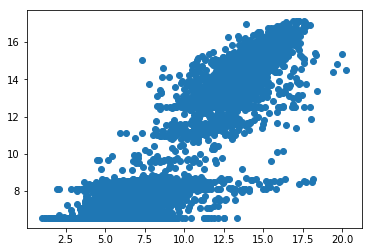

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
x = list(range(len(predictions)))
plt.scatter(y_test, predictions)

# Model Evaluation

Once all the models have been instantiated, it is necessary to test them to assess the accuracy. To test a model, 
the data is split into a training set and then a testing set the answers for which are withheld from the model. The model is trained on the training data (which includes the labels) and is then asked to make predictions on the test data. Whichever model performs the best on the test data will then be selected for optimization (hyperparameter tuning and feature engineering). 

In [24]:
# Function takes in a season and a model and runs all buildings through the model
# Function returns a dataframe with comprehensive results
def test_model(model_selection = 'random_forest', seasons = ["spring", "summer", "fall", "winter"]):
    # Empty dataframe for results
    results_df = pd.DataFrame()
    
    # Empty strings to append results to
    season_names = []
    buildings = []
    rmses = []
    r_squareds = []
    mape_results = []

    # Iterate through all files and make season predictions
    for file in os.listdir('./python_data/'):
        # Print file to gauge progress
        print(file)
        path = './python_data/' + file
        df = pd.read_csv(path)
        
        # Building identifier
        building = re.split('-|_', file)[1]
        
        for season in seasons:
            # Use the model selected
            if model_selection == 'random_forest':
                model, rmse, r_squared, mape_result = train_random_forest(df, season = season)

            elif model_selection == 'linear':
                model, rmse, r_squared, mape_result = train_linear_model(df, season = season)

            elif model_selection == 'svr':
                model, rmse, r_squared, mape_result = train_svr(df, season = season)

            elif model_selection == "pca_svr":
                model, rmse, r_squared, mape_result = train_pca_svr(df, season = season, n_components = 10)
            else:
                print('Entire a valid model ("random_forest", "linear", "svr")')
                return
        
    
            # Add results to strings
            season_names.append(season)
            buildings.append(building)
            rmses.append(rmse)
            r_squareds.append(r_squared)
            mape_results.append(mape_result)
        
    # Fill in dataframe of results
    results_df['building'] = buildings
    results_df['season'] = season_names
    results_df['rmse'] = rmses
    results_df['r_squared'] = r_squareds
    results_df['mape (%)'] = mape_results
    
    
    # Return comprehensive results
    return results_df

In [25]:
pca_svr_srp = test_model(model_selection = "pca_svr")

f-APS_weather.csv
f-CoServ_weather.csv
f-Kansas_weather.csv
f-NVE_weather.csv
f-PGE1_weather.csv
f-SDGE_weather.csv
f-SMUD_weather.csv
f-SRP_weather.csv


In [26]:
pca_svr_srp

,building,season,rmse,r_squared,mape (%)
0,APS,spring,1.415817,0.743649,17.688444
1,APS,summer,1.905991,0.753770,17.349742
2,APS,fall,1.966284,0.618709,20.381666
3,APS,winter,1.366203,0.499507,17.416810
4,CoServ,spring,0.086408,0.510416,47.030024
5,CoServ,summer,0.063972,0.671139,38.088296
6,CoServ,fall,0.078405,0.423489,49.181902
7,CoServ,winter,0.136244,0.497089,56.743886
8,Kansas,spring,1.146413,0.704198,18.280584
9,Kansas,summer,1.796629,0.732365,25.207834


# Model Comparison

Of course, once all the models have been developed, they must be compared to one another. I will use the defaults for each algorithm and evaluate all the buildings across all the seasons. The best performing model will be selected for hyperparameter optimization. There are a number of parameters to select for the SVM and Random Forest, but at this point, I want to merely assess the baseline accuracy with the defaults. 

In [126]:
# Takes in a directory and compares all models across all seasons
# Evaluation metrics: r_squared, rmse, and mape; models: linear regression, random forest ensemble, support vector regressor
def compare_models(directory = 'python_data/'):
    # Columns of results
    column_names = ['building', 'season', 'linear_r_squared', 'linear_rmse', 'linear_mape', 'random_forest_r_squared', 
                    'random_forest_rmse', 'random_forest_mape', 'svr_r_squared', 'svr_rmse', 'svr_mape']
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    num_files = len(os.listdir(directory))
    
    n_rows = len(seasons) * num_files
    
    # Create dataframe with initially all zeros
    complete_results = pd.DataFrame(data = np.zeros([n_rows, len(column_names)]), columns = column_names)
    # Index for locating rows in dataframe
    index = 0
    
    # Iterate through all seasons
    for season in ['spring', 'summer', 'fall', 'winter']:
        
        # Iterate through all files in directory
        for f in os.listdir(directory):
            # Establish results list and add name and season
            results = []
            building_name = re.split('-|_', f)[1]
            results.append(building_name)
            results.append(season)
            df = pd.read_csv(directory + f)
            
            # Linear Model
            linear_model, linear_rmse, linear_r_squared, linear_mape_result = train_linear_model(df, season = season)
            results.append(linear_r_squared)
            results.append(linear_rmse)  
            results.append(linear_mape_result)
                        
            # Random Forest
            rf_model, rf_rmse, rf_r_squared, rf_mape_result = train_random_forest(df, season = season)
            results.append(rf_r_squared)
            results.append(rf_rmse)
            results.append(rf_mape_result)
            
            # SVR
            svr_model, svr_rmse, svr_r_squared, svr_mape_result = train_svr(df, season = season)
            results.append(svr_r_squared)
            results.append(svr_rmse)
            results.append(svr_mape_result)
            
            # Deep Neural Network
            # dnn_saver, dnn_rmse, dnn_r_squared, dnn_mape_result = train_dnn(df, season = season)
            # results.append(dnn_r_squared)
            # results.append(dnn_rmse)
            # results.append(dnn_mape_result)
            
            # Add the results to the dataframe at the next row
            complete_results.iloc[index, :] = results
            
            # Increase the index by one
            index = index + 1
            
        print(season)
    return complete_results
        

In [127]:
complete_test_results = compare_models()

spring
summer
fall
winter


In [153]:
path = 'results.feather'
feather.write_dataframe(complete_test_results, path)

In [130]:
full_test_results = complete_test_results[complete_test_results['building'] != 0]

In [131]:
print('Linear Model average MAPE: {:0.4f}'.format(np.mean(full_test_results['linear_mape'])))
print('Random Forest average MAPE {:0.4f}'.format(np.mean(full_test_results['random_forest_mape'])))
print('SVR with RBF average MAPE  {:0.4f}'.format(np.mean(full_test_results['svr_mape'])))

Linear Model average MAPE: 39.1466
Random Forest average MAPE 7.1169
SVR with RBF average MAPE  26.6159


# Hyperparamter Tuning

The Random Forest performs best by far on the test data. The next step is to optimize the hyperparameters for the model. I was using the default hyperparameters for the Random Forest in sklearn with 100 estimators. 

In [142]:
rf_parameters = {
    'n_estimators': [int(x) for x in list(np.linspace(10, 200, num = 10))],
    'max_features': ['auto', 0.5, 0.8],
    'max_depth': [None, 10],
    'min_samples_split': [2, 4, 8]
}

rf_model = RandomForestRegressor()
random_search = RandomizedSearchCV(rf_model, rf_parameters, n_iter = 50, 
                                   verbose = 2, scoring = None)

In [143]:
srp_summer_df = pd.read_csv('python_data/f-SRP_weather.csv')
X, y = get_features_labels(srp_summer_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None, total=  17.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s


[CV] n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None, total=18.0min
[CV] n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None 
[CV]  n_estimators=200, min_samples_split=2, max_features=auto, max_depth=None, total=77.0min
[CV] n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None 
[CV]  n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None, total=   9.0s
[CV] n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None 
[CV]  n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None, total=   9.4s
[CV] n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None 
[CV]  n_estimators=178, min_samples_split=4, max_features=0.8, max_depth=None, total=   9.3s
[CV] n_estimators=31, min_samples_split=8, max_features=0.5, max_depth=None 
[CV]  n_estimators=31, min_samples_split=8, max_features=0.5, ma

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 110.1min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 0.5, 0.8], 'max_depth': [None, 10], 'min_samples_split': [2, 4, 8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [145]:
predictions = random_search.predict(X_test)
mape(y_test, predictions)

3.8795419999999998

In [146]:
smud_summer_df = pd.read_csv('python_data/f-SMUD_weather.csv')
X, y = get_features_labels(smud_summer_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

random_search_smud = RandomizedSearchCV(rf_model, rf_parameters, n_jobs=-1, n_iter = 100, verbose = 2)

In [147]:
random_search_smud.fit(X_train, y_train)
predictions = random_search_smud.predict(X_test)
print("test mape: {:0.6f}".format(mape(y_test, predictions)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.5min finished


test mape: 8.120253


In [149]:
random_search_smud
random_search_smud.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.size"] = 14

def plot_building(df, season = 'summer'):
    # Reuslts of training and prediction
    model, rmse, r_squared, mape_result, predictions, y_test = train_random_forest(df, season, return_pred = True)
    
    print('rmse: {:0.4f} mape: {:0.4f} r_squared: {:0.4f}'.format(rmse, mape_result, r_squared))
    
    plt.scatter(predictions, y_test);
    plt.ylabel('True Value (kWh)');
    plt.xlabel('Prediction Value (kWh)');
    plt.title('{} True vs. Predicted Value with Random Forest Model'.format(season));

In [ ]:
aps_df = pd.read_csv('./data/f-APS_weather.csv')
plot_building(aps_df)

## Feature Importances 


The random forest model is able to return the feature importances which can be useful for determining which variables are most closely tied to energy consumption. These are relative and not absolute, but can be used for comparison.

In [13]:
def building_feature_importances(df, season = 'summer'):
    print('{:20} Importance\n'.format('Variable'))
    model, rmse, r_squared, mape_result = train_random_forest(df, season)
    feature_importances = model.feature_importances_
    feature_importances = sorted(feature_importances, key = lambda x: x, reverse = True)
    col_names = get_features_labels(df, names = True)
    for col_name, importance in zip(col_names, feature_importances):
        print('{:20} {:0.5f}'.format(col_name, importance))

In [14]:
aps_df = pd.read_csv('python_data/f-APS_weather.csv')
building_feature_importances(aps_df)

Variable             Importance

num_time             0.17037
ghi                  0.16755
dif                  0.13057
gti                  0.11836
temp                 0.09185
rh                   0.07071
pwat                 0.06382
ws                   0.05114
month                0.03118
day                  0.01789
season_day           0.01629
sun_rise_set_rise    0.01619
sun_rise_set_set     0.01413
biz_day_0            0.01168
biz_day_1            0.01144
day_of_week_Fri      0.00670
day_of_week_Mon      0.00362
day_of_week_Sat      0.00165
day_of_week_Sun      0.00117
day_of_week_Thu      0.00099
day_of_week_Tue      0.00091
day_of_week_Wed      0.00087
week_day_end_day     0.00082
week_day_end_end     0.00008


In [ ]:
def complete_model(filepath, plot = False):
    building_name = re.split('-|_', filepath)[1]
    results_dict = {}
    df = pd.read_csv(filepath)
    for index, season in enumerate(['spring', 'summer', 'fall', 'winter']):
        model, rmse, r_squared, mape, predictions, y_true = train_random_forest(df, season = season, return_pred = True)
        results_dict[season] = {'model': model, 'rmse': rmse, 'r_squared': r_squared}
        colors = ["green", "red", "orange", "blue"]
        if plot:
            plt.figure(figsize = (10, 20))
            plt.subplot(4, 1, index + 1)
            plt.scatter(predictions, y_true, color = colors[index])
            plt.ylabel('True Value of Electricity Consumption');
            plt.xlabel('Prediction Value of Electricity Consumption');
            plt.title('%s %s True vs. Predicted Energy with Random Forest Model'% (building_name, season));
            print('R-Squared: {:0.4f} rmse: {:0.4f}'.format(r_squared, rmse))
            plt.show()
            
    return results_dict

In [ ]:
kansas_results = complete_model('./data/f-Kansas_weather.csv', plot = True)

In [ ]:
aps_df = pd.read_csv('./data/f-APS_weather.csv')

In [ ]:
def predict_mid(df):
    results_df = pd.DataFrame()
    results_df['forecast'] = df['forecast']
    results_df['timestamp'] = df['timestamp']
    
    # Predicts middle 25% of data for each season
    for index, season in enumerate(["spring", "summer", "fall", "winter"]):
        
        X, y, season_dates, names = get_features_labels(df, season = season, return_dates = True, names = True)
        month_index = names.index('month')
        
        # Take middle 25% of data for testing
        start_index = round(0.375 * y.shape[0])
        stop_index = round(0.625 * y.shape[0])

        # Join arrays together adding rows
        X_train_beginning = X[0:start_index]
        X_train_end = X[stop_index:]
        X_train = np.concatenate((X_train_beginning, X_train_end), axis = 0)
        X_test = X[start_index: stop_index]
        
        # Do same with features
        y_train_beginning = y[0:start_index]
        y_train_end = y[stop_index:]
        y_train = np.concatenate((y_train_beginning, y_train_end), axis = 0)
        y_test = y[start_index:stop_index]
        
        model = RandomForestRegressor(n_estimators = 100, criterion = 'mse')
        
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_test)
        
        predictions_df = pd.DataFrame()
        predictions_df['timestamp'] = season_dates[start_index:stop_index]
        predictions_df[season] = predictions
        
        results_df = pd.merge(results_df, predictions_df, how = 'outer', on = 'timestamp')
        results_df[season] = np.nan_to_num(results_df[season])
        
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        print('Season {}; RMSE on test data: {:0.4f}'.format(season, rmse))
        
        x_values = range(0, len(y_train) + len(y_test))
        
        if season.lower() == "spring":
            spring_df = pd.DataFrame()
            spring_df['timestamp'] = [parser.parse(date) for date in season_dates[start_index:stop_index]]
            spring_df['predictions'] = predictions
            datetimes = pd.date_range('2016-03-01 00:00:00', periods = len(x_values), freq = '0.25H').tolist()
        elif season.lower() == "summer":
            summer_df = pd.DataFrame()
            summer_df['timestamp'] = [parser.parse(date) for date in season_dates[start_index:stop_index]]
            summer_df['predictions'] = predictions
            datetimes = pd.date_range('2016-06-01 00:00:00', periods = len(x_values), freq = '0.25H').tolist()
        elif season.lower() == "fall":
            fall_df = pd.DataFrame()
            fall_df['timestamp'] = [parser.parse(date) for date in season_dates[start_index:stop_index]]
            fall_df['predictions'] = predictions
            datetimes = pd.date_range('2016-08-01 00:00:00', periods = len(x_values), freq = '0.25H').tolist()
        elif season.lower() == "winter":
            winter_df = pd.DataFrame()
            winter_df['timestamp'] = [parser.parse(date) for date in season_dates[start_index:stop_index]]
            winter_df['predictions'] = predictions
            datetimes = pd.date_range('2016-12-01 00:00:00', periods = len(x_values) , freq = '0.25H').tolist()
        
        datetimes_test = datetimes[start_index:stop_index]
        
        fig, ax = plt.subplots(figsize = (15, 6))
        
        datemin = datetimes[0]
        datemax = datetimes[-1]
        
        ax.plot(datetimes, y, color = "black")
        ax.plot(datetimes_test, predictions, color = "red")
        
        yearsFmt = mdates.DateFormatter('%Y-%m')
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.set_xlim(datemin, datemax)
        fig.autofmt_xdate()
        
        plt.legend(['Actual', 'Predicted'])
        plt.xlabel('')
        plt.ylabel('kWh')
        plt.title('{} Predicted vs. Actual Energy Consumption'.format(season))
        
        plt.show()
    
    fig, ax = plt.subplots(figsize = (15, 10))
    dt = [parser.parse(date) for date in results_df['timestamp']]
    datemin = dt[0]
    datemax = dt[-1]
    
    ax.plot(dt, results_df['forecast'], color = 'black')
    ax.plot(summer_df['timestamp'], summer_df['predictions'], color = 'yellow')
    ax.plot(fall_df['timestamp'], fall_df['predictions'], color = 'orange')
    ax.plot(winter_df['timestamp'], winter_df['predictions'], color = 'blue')
    ax.plot(spring_df['timestamp'], spring_df['predictions'], color = 'green')
    
    yearsFmt = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.set_xlim(datemin, datemax)
    fig.autofmt_xdate()
    
    plt.legend(['Actual', 'Predicted Summer', 'Predicted Fall', 'Predicted Winter', 'Predicted Fall'])
    plt.xlabel('')
    plt.ylabel('kWh')
    plt.title('Predicted vs. Actual Energy Consumption')
    plt.show()
    
    return results_df

In [ ]:
results = predict_mid(aps_df)

In [ ]:
smud_df = pd.read_csv('./data/f-SMUD_weather.csv')
results_smud = predict_mid(smud_df)

# TPOT: Autonomous Model Evaluation

TPOT is a library that automatically runs a machine learning dataset through a number of different models to find the one best suited to the data. It can be used to find the best model for a particular dataset or problem.

In [ ]:
aps_df = pd.read_csv('./python_data/f-APS_weather.csv')
X, y = get_features_labels(aps_df, season = 'summer')
X_train, X_test, y_train, y_test = train_test_split(X, y)
tpot_aps = TPOTRegressor(generations = 10, population_size = 10, cv = 2, max_eval_time_mins = 2, verbosity = 2)
tpot_aps.fit(X_train, y_train)

In [ ]:
tpot_aps.export('./tpot_pipelines/aps_summer_pipe.py')
tpot_aps.fitted_pipeline_ 

In [ ]:
mape(y_test, tpot_aps.predict(X_test))

In [ ]:
tpot_aps.evaluated_individuals_

In [ ]:
aps_df = pd.read_csv('./python_data/f-APS_weather.csv')
X, y = get_features_labels(aps_df, season = 'summer')
X_train, X_test, y_train, y_test = train_test_split(X, y)
tpot_aps_2 = TPOTRegressor(generations = 10, population_size = 10, cv = 2, max_eval_time_mins = 2, verbosity = 2)
tpot_aps_2.fit(X_train, y_train)

In [ ]:
tpot_aps_2.export('./tpot_pipelines/aps_summer_pipe.py')
tpot_aps_2.fitted_pipeline_ 

In [ ]:
predictions = tpot_aps_2.predict(X_test)
print('Mean absolute percentage error: {}'.format(mape(y_test, predictions)))

# Tree Visualization

A Random Forest is composed of many individual decision trees (100) in this case. Each decision tree has its own thresholds for regression, and it is possible to visualize these decision trees using graphviz.

In [ ]:
import graphviz

In [ ]:
from sklearn.tree import export_graphviz


srp_df = pd.read_csv('./python_data/f-SRP_weather.csv')
X, y, column_names = get_features_labels(srp_df, season = 'summer', names = True)

X_train, X_test, y_train, y_test = train_test_split(X, y)
rf_model = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
rf_model.fit(X_train, y_train)

In [ ]:
export_graphviz(rf_model.estimators_[42],
                feature_names =  column_names,
                filled = True,
                rounded = True)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('srp_tree.png')

In [ ]:
X_train.shape